## Setup evnironment

In [350]:
import mvranalysis as mvr
import os
import numpy as np
import pandas as pd
import scipy.io as sio
from glob import glob
import json

## Setup plotting

In [351]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from colorsys import hsv_to_rgb, rgb_to_hsv
%matplotlib inline
#import seaborn as sns
#sns.set_context('paper')
#sns.set_style('ticks')
from scipy import integrate
from scipy import interpolate

## Load trial data

In [548]:
path = '/Volumes/freeman/Nick/mVR/sessions/000084'
session = mvr.load_session(path)

In [549]:
maze = mvr.loadMazeMat(path+'/behavior')

OneChoiceRLcts.mat


In [550]:
#session.to_csv(path + '/behavior/session.csv')

#### Create trial summary

In [551]:
trial = session[['trialType','number']].groupby(['number'], sort=True).first()
trial = trial.join(session[['reward','number','rEnd','lEnd']].groupby(['number'], sort=True).max())

In [552]:
#Returns table of all trials and whether or not they entered a specific branch
def trialEntered(branchId):
    keep = session[['curBranchId','number']].groupby(['number'], sort=True).agg(lambda x : branchId in x.values)
    return keep
 

## Plot data

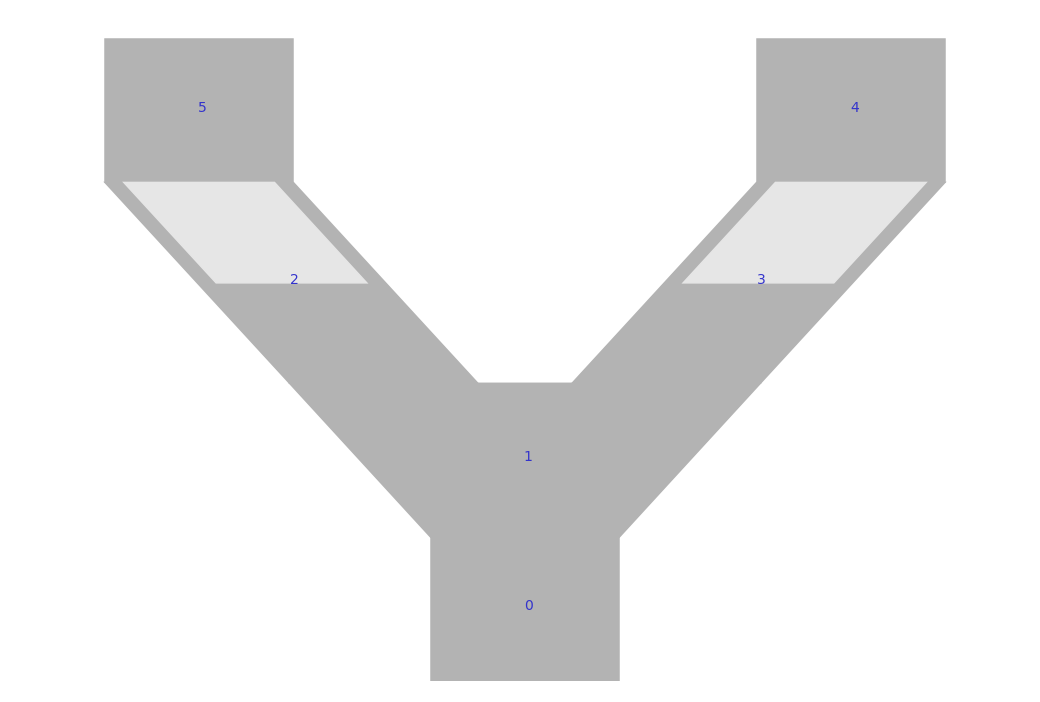

In [553]:
plt.figure(figsize=[18,12])
Id = 0
mvr.draw(maze[Id],True)

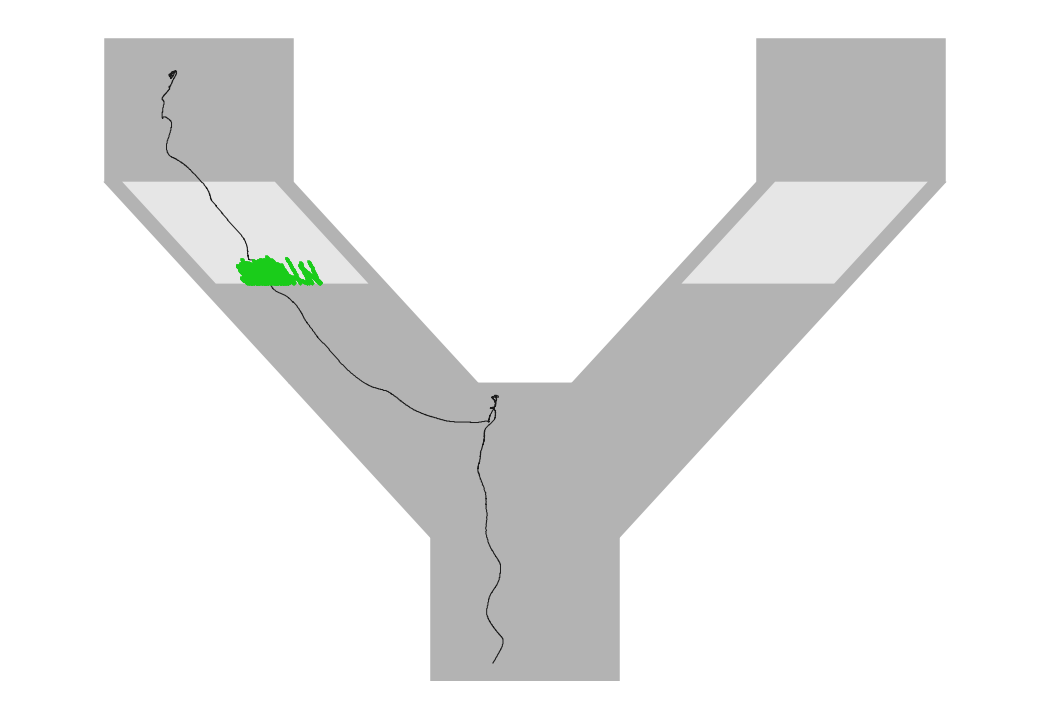

In [554]:
plt.figure(figsize=[18,12])
Id = 0
keep = trial[trial.trialType == Id].index.tolist()
mvr.draw(maze[Id],False)
mvr.trace(session, 102, [0.1, 0.1, 0.1])
#mvr.licks(session, keep, [0.9, 0.1, 0.1])
mvr.water(session, keep, [0.1, 0.8, 0.1])

In [555]:
def pathlength(x,y,degree=3)  :
    '''
    x and y arrays must have the same dimensions
    Implements arclength formula to estimate the total length of a fitted spline (cubic default)
    
    Returns: x(t) spline, y(t) spline, path length
    ''' 
    
    t = range(len(x)) #time series
    fx = interpolate.UnivariateSpline(t, x, k=degree)
    fy = interpolate.UnivariateSpline(t, y, k=degree)
    #print len(x),len(fx(t))
    x_coef = fx.get_coeffs()[~np.isnan(fx.get_coeffs())]
    y_coef = fy.get_coeffs()[~np.isnan(fy.get_coeffs())]
    
    dxdt = fx.derivative()
    dydt = fy.derivative()

    dx_array = [dxdt(xi) for xi in t]
    dy_array = [dydt(yi) for yi in t]

    dx2 = np.square(dx_array)
    dy2 = np.square(dy_array)

    hyp2 = np.add(dx2,dy2)
    integrand = np.sqrt(hyp2)

    length = sum(integrand)

    
    return fx, fy,length 

In [556]:
def fitpath(covariates,trial):
    if not isinstance(trial, (list, tuple)):
        trial = [trial]
    pathlengths = []    
    for t in trial :   
        xCord = session.xMazePos[(session.number == t) & ~session.iti].values[:-100]
        yCord = session.yMazePos[(session.number == t) & ~session.iti].values[:-100] 
    
        pathlengths.append(pathlength(xCord,yCord)[2])
    
    return pathlengths 

In [557]:
plen = fitpath(session,keep)
trial['Pathlengths'] = plen

In [558]:
def choicepath(covariates,trial):
    if not isinstance(trial, (list, tuple)):
        trial = [trial]
    pathlengths = []    
    for t in trial :   
        xCord = session.xMazePos[(session.number == t) & (session.curBranchId == 1) & ~session.iti].values
        yCord = session.yMazePos[(session.number == t) & (session.curBranchId == 1) & ~session.iti].values 
        #print len(xCord), len(yCord)
        if len(xCord)==0:
            pathlengths.append('NaN')
            continue
        pathlengths.append(pathlength(xCord,yCord)[2])
    
    return pathlengths 
choicelen = choicepath(session,keep)
trial['choicePath'] = choicelen


In [559]:
def initchoicepath(session,trial):
    if not isinstance(trial, (list, tuple)):
        trial = [trial]
    pathlengths = []    
    for t in trial : 
        inchoice = [(session.curBranchId==1) & (session.number==t)]
        if len(np.nonzero(inchoice)[1])==0:
            pathlengths.append(0)
            continue
        enter1 = np.nonzero(inchoice)[1][0]
        #print "enter 1 for trial"+str(t)+'='+str(enter1)
        inchoice = list(inchoice[0][enter1:])

        exit1 = enter1 + inchoice.index(0)
        #print "exit 1 for trial"+str(t)+'='+str(exit1)
        
        xCord = session.xMazePos[(session.trialIndex > enter1) & (session.trialIndex < exit1) & (session.number==t)].values
        yCord = session.yMazePos[(session.trialIndex > enter1) & (session.trialIndex < exit1) & (session.number==t)].values 
        #print len(xCord)
        pathlengths.append(pathlength(xCord,yCord)[2])
    
    return pathlengths 
initchoicelen = initchoicepath(session,keep)
trial['initChoicePath'] = initchoicelen

0
0
0
106


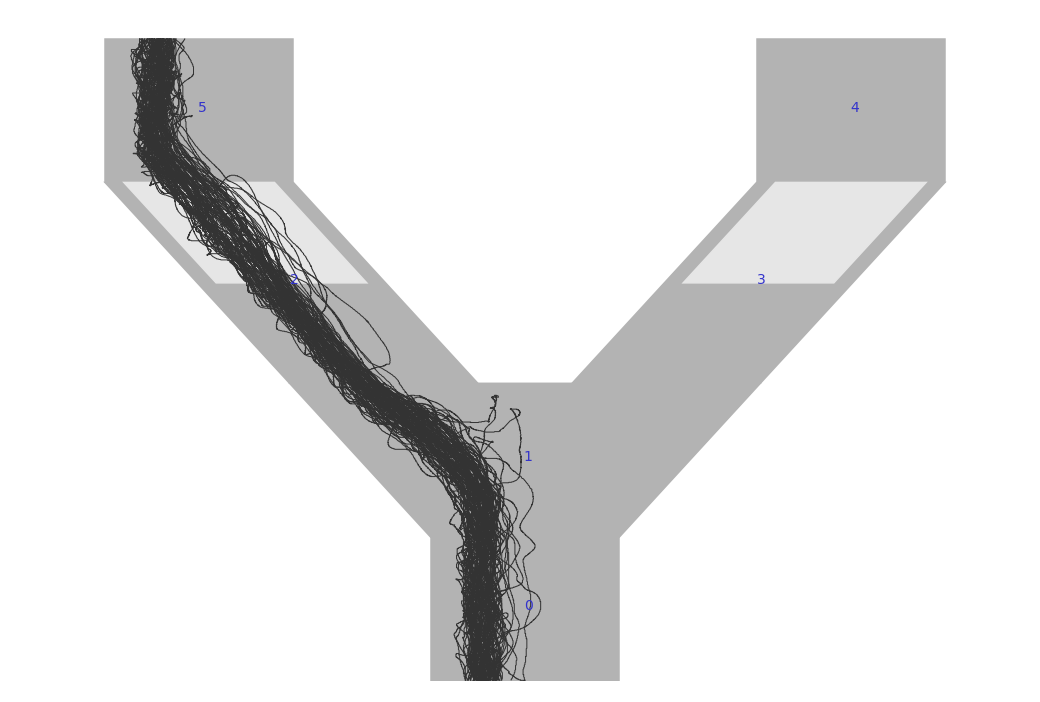

In [560]:
#For the unbiased maze 

plt.figure(figsize=[18,12])
Id = 0
mvr.draw(maze[Id],True)
branchId = 3
keepW = trialEntered(branchId)
branchId = 4
keepE = trialEntered(branchId)
branchId = 2
keepS = trialEntered(branchId)
branchId = 5
keepN = trialEntered(branchId)

keepR = trial[(keepS.curBranchId == False) & (keepE.curBranchId == True) & (trial.trialType == Id)].index.tolist()
print len(keepR)
mvr.trace(session, keepR, [0.7, 0.3, 0.3]) #chose right

keepRL = trial[(keepW.curBranchId == True) & (keepN.curBranchId == True) & (trial.trialType == Id)].index.tolist()
print len(keepRL)
mvr.trace(session, keepRL, [0.3, 0.7, 0.3]) #init choice right, exited left

keepLR = trial[(keepS.curBranchId == True) & (keepE.curBranchId == True) & (trial.trialType == Id)].index.tolist()
print len(keepLR)
mvr.trace(session, keepLR, [0.4, 0.5, 0.2]) #init choice left, exited right

keepL = trial[(keepW.curBranchId == False) & (keepN.curBranchId == True) & (trial.trialType == Id)].index.tolist()
print len(keepL)
mvr.trace(session, keepL, [0.2, 0.2, 0.2]) #chose left

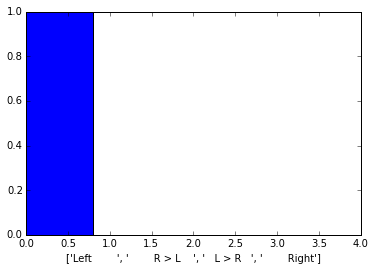

In [561]:
classified = [len(keepL), len(keepRL), len(keepLR),len(keepR)]
numtrls = len(trial)
classified = [x / float(numtrls) for x in classified]
plt.bar(range(0,len(classified)),classified)
plt.xlabel(['Left        ', '        R > L    ','   L > R   ', '        Right'])

In [562]:
#Total bias split, based on initial choices

percent_left = (len(keepL)+len(keepLR))/float(numtrls)
percent_right = (len(keepR)+len(keepRL))/float(numtrls)

print percent_left,percent_right

1.0 0.0


# Create dot plot

([<matplotlib.axis.YTick at 0x10fd1d9d0>,
 <a list of 2 Text yticklabel objects>)

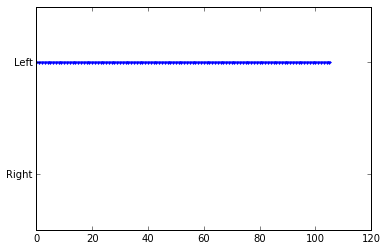

In [563]:
plt.plot(trialEntered(5),'.')
plt.ylim((-0.5,1.5))
plt.yticks([0,1],['Right', 'Left'])
#final trajectories, dead end or nah

In [564]:
#Classified into array

def init_choice(numtrials):    
    choices = ["" for x in range(numtrials)]

    for x in range(len(choices)):
        if x in keepR:
            choices[x] = "R"
        elif x in keepRL:
            choices[x] = "RL"
        elif x in keepLR:
            choices[x] = "LR"
        else:
            choices[x] = "L"
    return choices
choices = init_choice(numtrls)
print len(trial)
print len(choices)
trial ['Trajectory'] = choices
trial['initChoice']   = [x[:1] for x in choices] 


106
106


In [565]:
#Total bias split, based on initial choices

percent_left = (len(keepL)+len(keepLR))/float(numtrls)
percent_right = (len(keepR)+len(keepRL))/float(numtrls)
percent_qswitch = (len(keepRL) +len(keepLR))/float(numtrls)

print percent_left,percent_right, percent_qswitch

1.0 0.0 0.0


In [566]:
def completion(session, numtrials):
    finish = []
    for n in range(numtrials):
        start = session.time[session.number==n].min()
        stop = session.time[session.number==n].max()
        if (stop-start) > 119:
            entry = False
        else:
            entry = True
        finish.append(entry)
    return finish

complete = completion(session,numtrls)
trial['Completed'] = complete
#print trial.Completed

In [567]:
def trial_time(session, numtrials):
    seconds = []
    for n in range(numtrials):
        start = session.time[session.number==n].min()
        stop = session.time[session.number==n].max()
        seconds.append(stop-start)
    return seconds    
        
times = trial_time(session,numtrls)

trial['time'] = times

In [568]:
def choice_time(session,numtrials):
    think = []
    straight = []
    choicept = 1
    entrance = 0
    dt = 0.002
    for n in range(numtrials):
        in1 = len(session[session.number==n].time[session.curBranchId==choicept])*dt
        in0 = len(session[session.number==n].time[session.curBranchId==entrance])*dt
        
        think.append(in1)
        straight.append(in0)
    return think,straight

t_choosing,t_straight = choice_time(session,numtrls)
trial['timeStraight'] = t_straight
trial['timeChoice'] = t_choosing


In [569]:
def initchoice_time(session,numtrials):
    dt = 0.002 #seconds per timestep
    initchoice_t = []
    for n in range(numtrials):
        inchoice = [(session.curBranchId==1) & (session.number==n)]
        if len(np.nonzero(inchoice)[1])==0:
            initchoice_t.append(0)
            continue
        enter1 = np.nonzero(inchoice)[1][0]
        
        inchoice = list(inchoice[0][enter1:])
        exit1 = enter1 + inchoice.index(0)
        initchoice_t.append((exit1-enter1)*dt)
    return initchoice_t

initchoice_t= initchoice_time(session,numtrls)
trial['initChoiceTime'] = initchoice_t   

In [570]:
import math
def Idphi(x,y,degree=3):
    '''
    x and y arrays must have the same dimensions
    Implements arclength formula to estimate the total length of a fitted spline (cubic default)
    
    Returns: idphi
    ''' 
    
    t = range(len(x)) #time series
    dx_array = np.diff(x)
    dy_array = np.diff(y)
    d = range(len(dx_array))
    phi = [math.atan2(dy_array[i],dx_array[i]) for i in d]
    phi = np.unwrap(phi)
    phispline = interpolate.UnivariateSpline(range(len(phi)),phi, k=degree)
   
    dphispline = phispline.derivative()
    '''
    plt.plot(x,y)
    plt.xlim(0,70)
    plt.figure()
    plt.plot(phi)
    plt.plot(d,phispline(d))
    plt.figure()
    plt.plot(d,dphispline(d))
    '''
    
    dphi = [abs(i) for i in dphispline(d)]
    result = sum(dphi)
    
    return result

In [571]:
def get_idphi(session,trial):
    if not isinstance(trial, (list, tuple)):
        trial = [trial]
    idphi = []    
    for t in trial : 
        inchoice = [(session.curBranchId==1) & (session.number==t)]
        
        if len(np.nonzero(inchoice)[1])==0:
            idphi.append(np.nan)
            continue
        enter1 = np.nonzero(inchoice)[1][0]
        
        inchoice = list(inchoice[0][enter1:])

        exit1 = enter1 + inchoice.index(0)
        
        exitbranch = session.curBranchId[(session.trialIndex==exit1)].values[0]
        
        if not (exitbranch ==2 or exitbranch==3):
            idphi.append(np.nan)
            continue 
        
        xCord = session.xMazePos[(session.trialIndex > enter1) & (session.trialIndex < exit1) & (session.number==t)].values
        yCord = session.yMazePos[(session.trialIndex > enter1) & (session.trialIndex < exit1) & (session.number==t)].values 
       
        idphi.append(Idphi(xCord,yCord))
    return idphi

idphi = get_idphi(session,keep)
trial['IdPhi'] = idphi        

In [572]:
zidphi = ((trial.IdPhi - trial.IdPhi.mean())/trial.IdPhi.std(ddof=0))
#print zidphi
trial['zIdPhi'] = zidphi
#trial

In [573]:
newfolder = path+'/summary'

In [574]:
#os.mkdir(newfolder)

In [576]:
trial.to_csv(newfolder+ '/trial_summary84.csv')

In [578]:
print np.nanmean(trial.IdPhi)


2.32265427798
